In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
data_path = "../data/case_study_data_final.csv"
df = pd.read_csv(data_path).drop("index", axis=1)

### Check out the Data

In [38]:
df.sample(5)

,city,district,min_booking_duration,first_pic_category,beds,rooms,deposit,area,price,accommodates,number_of_pics,cleaning_fee,clicks
13571,992,1074,1,TERRACE,3,3,1250.0,100.0,1250.0,4.0,21.0,49.0,165
7025,1365,1392,9,LIVING_DINING_ROOM,2,2,500.0,58.0,800.0,2.0,7.0,250.0,0
12749,185,960,2,LIVING_DINING_ROOM,2,2,1200.0,52.0,1199.0,2.0,14.0,150.0,781
14105,141,759,3,LIVING_DINING_ROOM,2,2,3580.0,45.0,1790.0,2.0,6.0,100.0,611
2723,822,923,6,ROOM_BEDROOM,1,2,770.0,40.0,770.0,1.0,5.0,0.0,0


In [ ]:
numerical_feats = df.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

### II- Explore Label

#### A. Label Distribution

In [40]:
df[["clicks"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
clicks,15000.0,368.127533,934.179019,0.0,0.0,87.0,468.0,38458.0


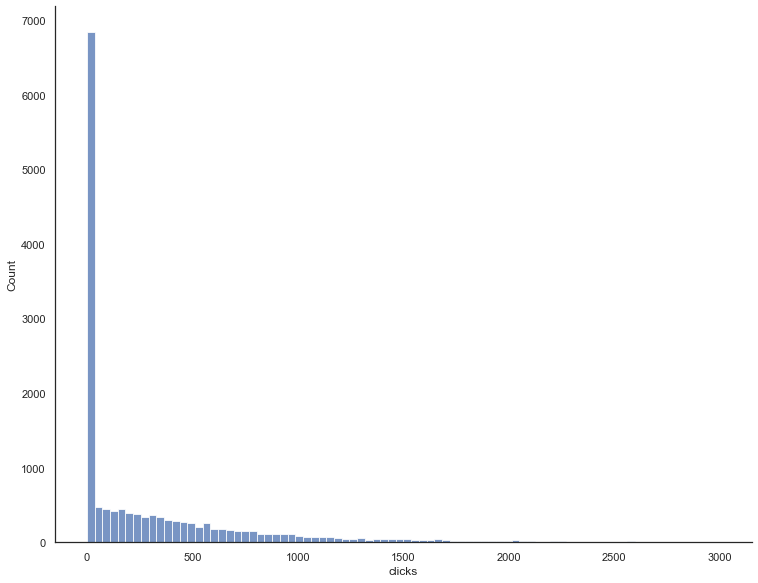

In [79]:
sns.set_color_codes(palette='deep')
sns.displot(df.clicks, height=8.27, aspect=10.7/8.27)

### How Many Zeros in the Data

In [108]:
len(df[df.clicks==0])/len(df)

0.4056203248197318

40% of the Posts have 0 clicks

In [80]:
print("Skewness: %f" % df['clicks'].skew())
print("Kurtosis: %f" % df['clicks'].kurt())

Skewness: 2.238872
Kurtosis: 5.788969


### Explore features

#### Correlation

<AxesSubplot:>

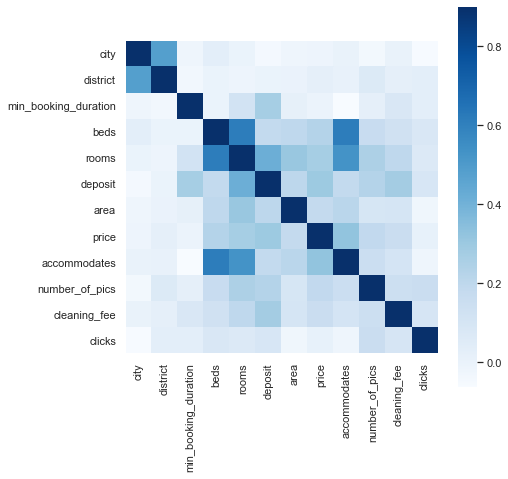

In [83]:
corr = df.corr()
plt.subplots(figsize=(7,7))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

In [76]:
q_h = df["clicks"].quantile(0.99)

In [77]:
df = df[df["clicks"]<q_h]

### Check Relationship Between Some Variables and Label

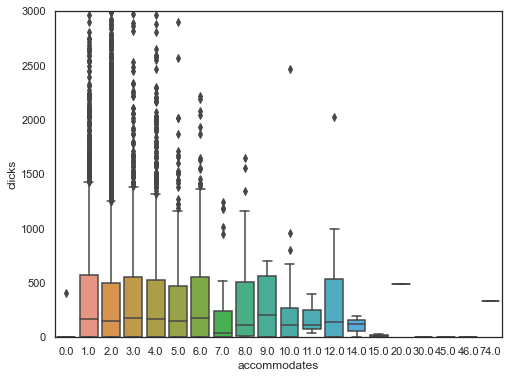

In [82]:
data = pd.concat([df['clicks'], df['accommodates']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=df['accommodates'], y="clicks", data=data)
fig.axis(ymin=0, ymax=3000);

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  14850 non-null  int64  
 1   district              14850 non-null  int64  
 2   min_booking_duration  14850 non-null  int64  
 3   first_pic_category    13547 non-null  object 
 4   beds                  14850 non-null  int64  
 5   rooms                 14850 non-null  int64  
 6   deposit               14850 non-null  float64
 7   area                  13151 non-null  float64
 8   price                 14849 non-null  float64
 9   accommodates          13118 non-null  float64
 10  number_of_pics        13552 non-null  float64
 11  cleaning_fee          13300 non-null  float64
 12  clicks                14850 non-null  int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 1.6+ MB


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


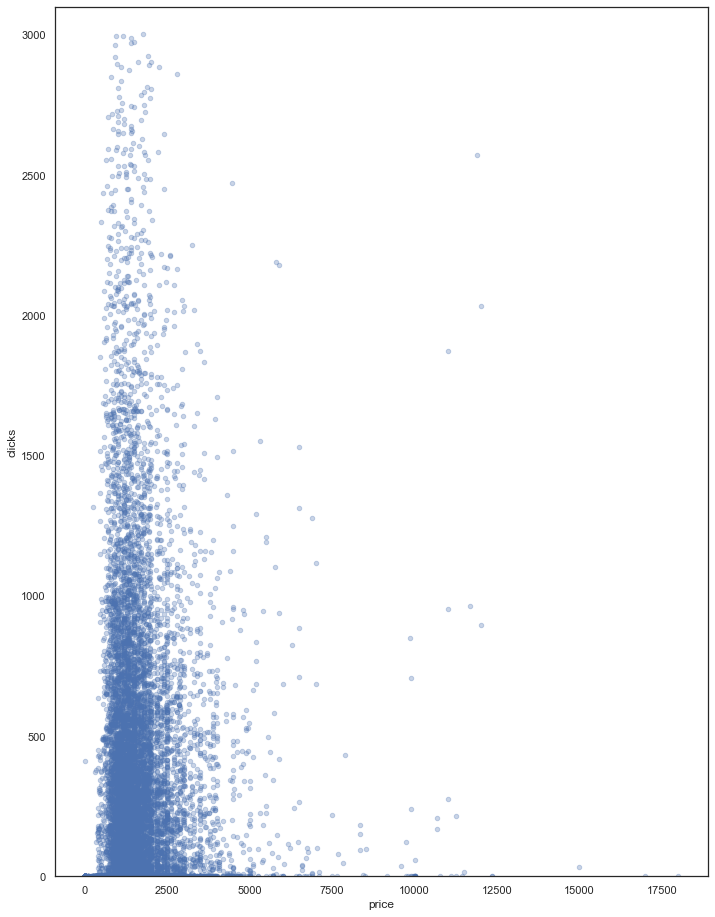

In [102]:
df = df[df["price"]<20000]
data = pd.concat([df['clicks'], df['price']], axis=1)
data.plot.scatter(x='price', y='clicks', alpha=0.3, ylim=(0,3100));

### District with Most Clicks

In [123]:
df.groupby("city").agg({"clicks": "mean", "city": "count"})\
                  .rename({"city": "count"}, axis=1)\
                  .apply(lambda x:round(x,2))\
                  .sort_values(by="count", ascending=False)\
                  .head(100)

,clicks,count
city,,
141,363.23,5337
465,262.84,1303
822,250.36,1098
271,327.98,842
349,287.84,742
...,...,...
1010,612.38,8
46,401.38,8
608,171.38,8


In [98]:
df.groupby("first_pic_category").agg({"clicks": "mean", "first_pic_category": "count"})\
                                .rename({"first_pic_category": "count"}, axis=1)\
                                .apply(lambda x:round(x,2))\
                                .sort_values(by="clicks", ascending=False)\
                                .head(10)

,clicks,count
first_pic_category,,
UNCATEGORIZED,437.21,448
WALK_IN_CLOSET,355.59,22
ROOM_BEDROOM,351.14,2452
LIVING_DINING_ROOM,346.23,7764
OUTDOOR_HOUSE,343.22,271
PARKING,337.50,2
MOUNTAIN_VIEW,331.00,5
KITCHEN,330.51,873
HALL_CORRIDOR,329.86,231


### Missing Values

In [13]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
accommodates,1732,0.115467
area,1699,0.113267
cleaning_fee,1550,0.103333
first_pic_category,1303,0.086867
number_of_pics,1298,0.086533
price,1,0.000067
clicks,0,0.000000
deposit,0,0.000000
rooms,0,0.000000
beds,0,0.000000


In [116]:
df.groupby("district").city.nunique().sort_values(ascending=False).head(15)

district
1414    18
356      3
311      3
959      3
223      2
650      2
644      2
589      2
816      2
568      2
156      2
856      2
539      2
207      2
893      2
Name: city, dtype: int64

In [117]:
df["district"].nunique()

954

In [120]:
df[df.city==1225]

,city,district,min_booking_duration,first_pic_category,beds,rooms,deposit,area,price,accommodates,number_of_pics,cleaning_fee,clicks
6683,1225,836,1,LIVING_DINING_ROOM,3,3,2000.0,75.0,2000.0,3.0,9.0,100.0,1926


### Price Analysis

<AxesSubplot:xlabel='price', ylabel='Count'>

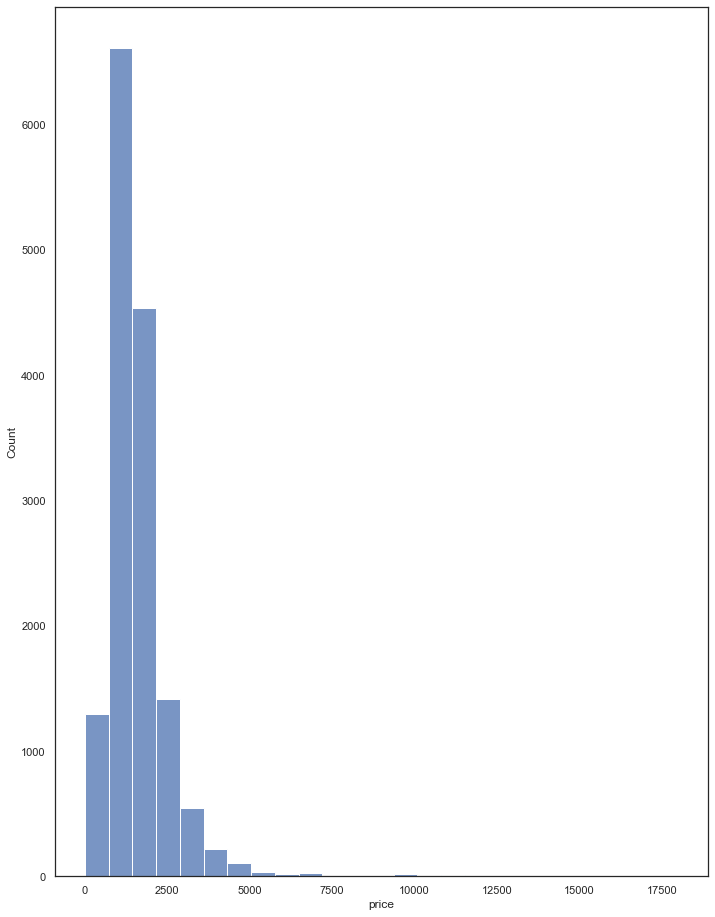

In [111]:
sns.set_color_codes(palette='deep')
sns.histplot(df.price, bins = 25)

In [15]:
df.cleaning_fee.describe()

count    13450.000000
mean        92.181859
std        126.153538
min          0.000000
25%         20.000000
50%         80.000000
75%        150.000000
max      10000.000000
Name: cleaning_fee, dtype: float64

In [16]:
df[df.cleaning_fee==10000]

,city,district,min_booking_duration,first_pic_category,beds,rooms,deposit,area,price,accommodates,number_of_pics,cleaning_fee,clicks
6313,141,893,3,LIVING_DINING_ROOM,5,6,5950.0,280.0,5950.0,7.0,27.0,10000.0,0
